[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/Speech-Interaction-Technology-Aalto-U/itsp/HEAD?labpath=Modelling%2Fgriffinlib.ipynb)

# The Griffin-Lim algorithm: Signal estimation from modified short-time Fourier transform

Many speech processing algorithms, those of [speech enhancement](content:noiseattenuation) in particular, modify or estimate the magnitude spectrum, such that the phase spectrum is either very noisy or completely unavailable. Yet it is desirable to recover an estimate of the complex spectrum. The method known as the *Griffin-Lim* and its improvement, the fast Griffin-Lim algorithms, does exactly that {cite}`griffin1984signal,perraudin2013fast`. As input, they take a magnitude (or power, or log-power) spectrogram, and they produce a complex-valued spectrogram whose magnitude is consistent with the desired magnitude.

In isolation, reconstructing a complex signal $x=a + ib$ from its magnitude only $|x|=\sqrt{a^2 + b^2}$ is clearly impossible. From one value, the magnitude, we cannot reconstruct both the real and imaginary parts $a$ and $b$. From an ensemble of correlated values, we however *can* reconstruct the complex value.

For reconstruction, the Griffin-Lim uses the leakage between time-frequency components. Most prominently, since subsequent frames overlap in time, they see partly the same information. Windowing causes leakage also over frequencies, such that nearby frequencies also share partly the same information. The share information has both magnitude and phase components, such that we can from the magnitude-only information estimate the phase component. 

The basic algorithm is an iteration which takes the prior estimate of the complex spectrogram, applies the STFT backward and forward, and the reapplies the desired magnitude. In each back-and-forward step, information leaks between time-frequency bins taking the estimate closer to a consistent estimate. By a consistent estimate, we here refer to an estimate whose magnitude is equal to the desired level and whose phase is unchanged by the back-and-forward SFTF. Any deviation from the consistent estimate would spread out and dilluted in the back-and-forward step such that the iteration converges to a consistent state. 

In the two examples below, you see sinusoids of different frequencies reconstructed from their magnitude spectrograms. In the two examples, you see that the higher-frequency sinusoid is recovered decently, but with the lower frequency, recovery becomes difficult. The algorithm clearly arrives at a local minimum which it is unable to escape.

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [2]:
# example signal
original_waveform = np.sin(np.linspace(0,221,400))
_,_,original_spectrogram = scipy.signal.stft(original_waveform,nperseg=100, return_onesided=True)
frames = original_spectrogram.shape[1]

# initialize target magnitude spectrogram
magnitude_spectrogram = np.abs(original_spectrogram)

# initial guess of complex spectrogram = random phase
spectrogram = magnitude_spectrogram*np.exp(1j*2*np.pi*np.random.rand(51,frames)) 

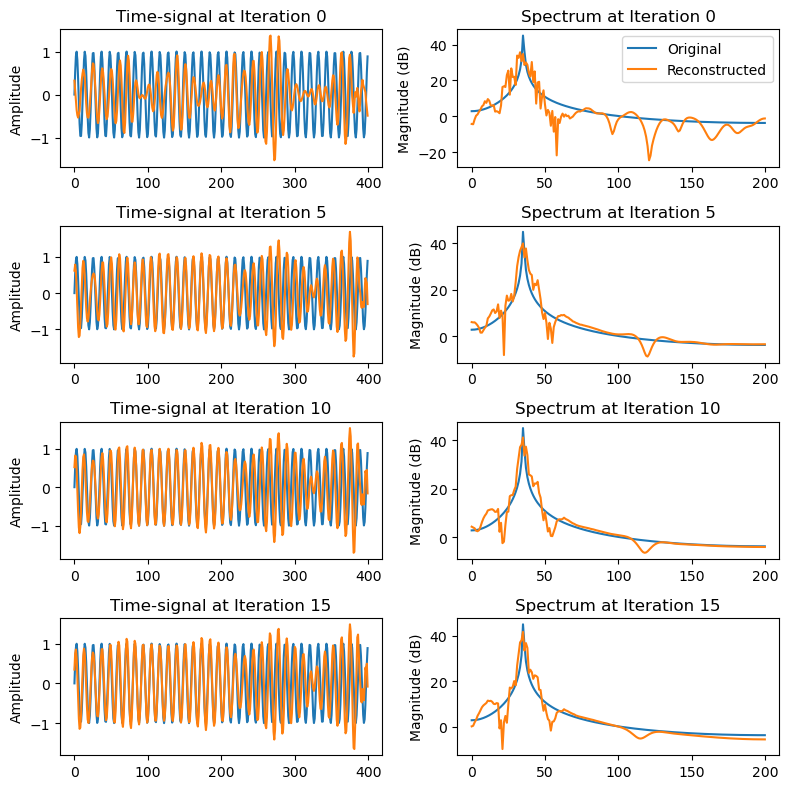

In [3]:
plt.figure(figsize=(8,8))
N = 4
K = 5
for h in range(N*K - K+1):
    _,waveform = scipy.signal.istft(spectrogram, nperseg=100, input_onesided =True, boundary=True)
    waveform = np.real(waveform)
    _,_,spectrogram = scipy.signal.stft(waveform,    nperseg=100, return_onesided=True)
    spectrogram = np.exp(1j*np.angle(spectrogram))*magnitude_spectrogram
    
    if h % K == 0:
        k = h//K
        plt.subplot(N,2,2*k+1)
        plt.plot(original_waveform)
        plt.plot(waveform)
        plt.title(f"Time-signal at Iteration {h}")
        plt.ylabel('Amplitude')
        
        plt.subplot(N,2,2*k+2)
        plt.plot(20*np.log10(np.abs(scipy.fft.rfft(original_waveform))),label='Original')
        plt.plot(20*np.log10(np.abs(scipy.fft.rfft(waveform))),label='Reconstructed')
        plt.title(f"Spectrum at Iteration {h}")
        plt.ylabel('Magnitude (dB)')
        if h==0: plt.legend()
        
    
plt.tight_layout()
plt.show()

In [4]:
# example signal
original_waveform = np.sin(np.linspace(0,17,400))
_,_,original_spectrogram = scipy.signal.stft(original_waveform,nperseg=100, return_onesided=True)
frames = original_spectrogram.shape[1]

# initialize target magnitude spectrogram
magnitude_spectrogram = np.abs(original_spectrogram)

# initial guess of complex spectrogram = random phase
spectrogram = magnitude_spectrogram*np.exp(1j*2*np.pi*np.random.rand(51,frames)) 

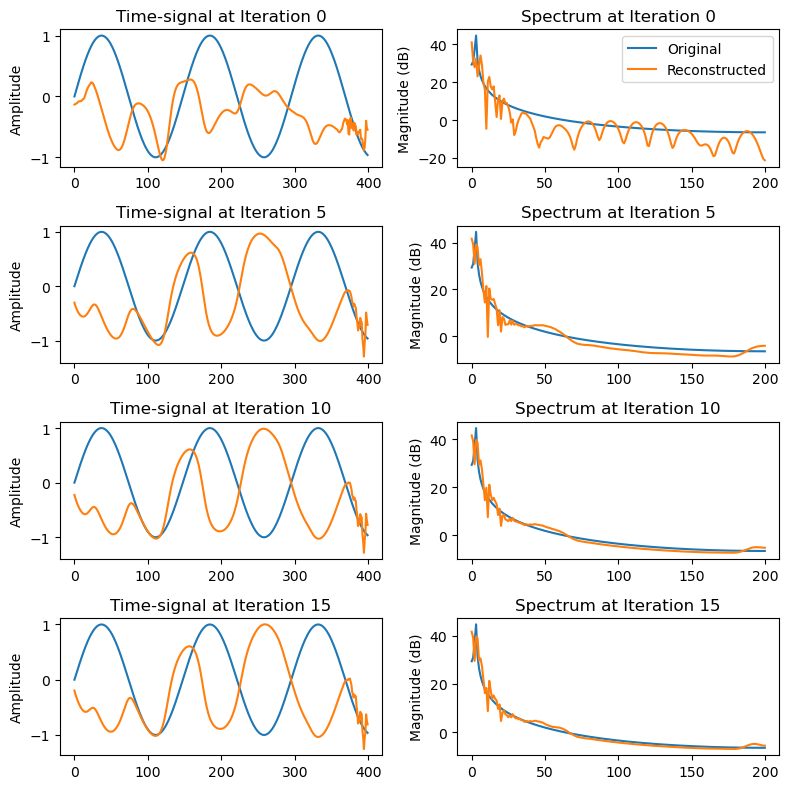

In [5]:
plt.figure(figsize=(8,8))
N = 4
K = 5
for h in range(N*K - K+1):
    _,waveform = scipy.signal.istft(spectrogram, nperseg=100, input_onesided =True, boundary=True)
    waveform = np.real(waveform)
    _,_,spectrogram = scipy.signal.stft(waveform,    nperseg=100, return_onesided=True)
    spectrogram = np.exp(1j*np.angle(spectrogram))*magnitude_spectrogram
    
    if h % K == 0:
        k = h//K
        plt.subplot(N,2,2*k+1)
        plt.plot(original_waveform)
        plt.plot(waveform)
        plt.title(f"Time-signal at Iteration {h}")
        plt.ylabel('Amplitude')
        
        plt.subplot(N,2,2*k+2)
        plt.plot(20*np.log10(np.abs(scipy.fft.rfft(original_waveform))),label='Original')
        plt.plot(20*np.log10(np.abs(scipy.fft.rfft(waveform))),label='Reconstructed')
        plt.title(f"Spectrum at Iteration {h}")
        plt.ylabel('Magnitude (dB)')
        if h==0: plt.legend()
    
plt.tight_layout()
plt.show()

To demonstrate performance for a real speech signal, consider the following sample.

In [6]:
# Initialization for all
from scipy.io import wavfile
import scipy
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd


filename = 'sounds/griffinlim.wav'


# read from storage
fs, data = wavfile.read(filename)

seconds = 5  # Duration of recording
window_length_ms=30
window_length = int(window_length_ms*fs/2000)*2

In [7]:
# example signal
_,_,original_spectrogram = scipy.signal.stft(
    data,
    nperseg=window_length, 
    return_onesided=True)
frames = original_spectrogram.shape[1]
frequency_elements = original_spectrogram.shape[0]

# initialize target magnitude spectrogram
magnitude_spectrogram = np.abs(original_spectrogram)

# initial guess of complex spectrogram = random phase
spectrogram = magnitude_spectrogram*np.exp(1j*2*np.pi*np.random.rand(frequency_elements,frames)) 

In [8]:
for h in range(32):
    _,waveform = scipy.signal.istft(
        spectrogram, 
        nperseg=window_length, 
        input_onesided =True, 
        boundary=True)
    waveform = np.real(waveform)
    _,_,spectrogram = scipy.signal.stft(
        waveform,    
        nperseg=window_length, 
        return_onesided=True)
    spectrogram = np.exp(1j*np.angle(spectrogram))*magnitude_spectrogram
    
_,waveform = scipy.signal.istft(
        spectrogram, 
        nperseg=window_length, 
        input_onesided =True, 
        boundary=True)
waveform = np.real(waveform)

In [9]:
ipd.display(ipd.HTML('Original'))
ipd.display(ipd.Audio(data,rate=fs))
ipd.display(ipd.HTML('Reconstructed'))
ipd.display(ipd.Audio(waveform,rate=fs))

In the reconstructed output, it is relatively easy to perceive a distortion caused by phase-reconstruction, though the overall quality is good.

## References

```{bibliography}
:filter: docname in docnames
```